## Imports

In [1]:
import sys
from multiprocessing import Pool

import arviz as az
import corner
import matplotlib.pyplot as plt
import numpy as np
from arviz.labels import MapLabeller
from eryn.ensemble import EnsembleSampler
from eryn.moves import (
    CombineMove,
    DistributionGenerateRJ,
    GaussianMove,
    MTDistGenMoveRJ,
    StretchMove,
)
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from eryn.utils import TransformContainer
from eryn.utils.utility import groups_from_inds
from scipy.stats import invgamma, norm
from sklearn.model_selection import KFold, train_test_split

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

%matplotlib inline

## Dataset

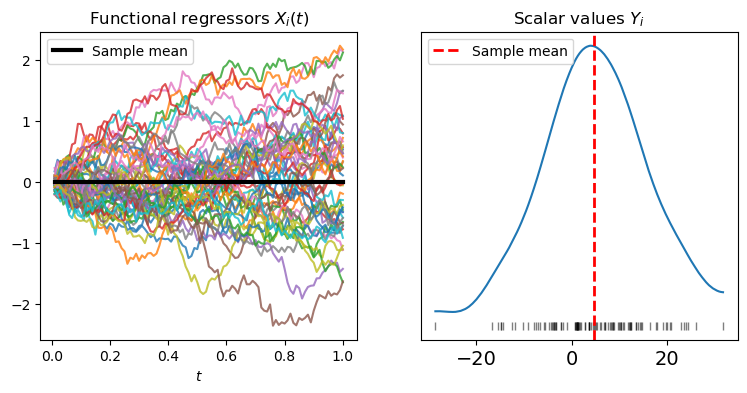

In [2]:
# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [5, 0.6],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)
y_noiseless = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, 0.0, rng=rng
)

# Train/test split and standardize
indices = np.arange(n_train + n_test)  # for future convenience
X, X_test, Y, Y_test, idx_train, idx_test = train_test_split(
    x, y, indices, train_size=n_train, random_state=seed
)
X, X_test = simulation.standardize_predictors(X, X_test)
# Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train // 2,
)

## Model RKHS

### Likelihood

**TODO likelihood**

  Vectorize and check if it is faster

In [3]:
def log_likelihood(theta, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
          In other words, on each call to this function the shape varies according to how many leaves are active.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_components, theta_common = theta
    beta = theta_components[:, 0]
    tau = theta_components[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5 * np.einsum("i,i->", diff, diff) / sigma2

    return ll


"""
theta = [th1, th2]. En este caso, th1 es un array (N, 2) y th2 es (ntemps*nwalkers, 1). Contienen el valor
de todos los parámetros, th1=(b, t) y th2=(alpha0,sigma2), para todos los árboles que tenemos. Como el número
de b's y t's de cada árbol es variable, N dependerá de los índices que estén activos en cada momento.
Concretamente, N=sum(inds["components"]). 

En cuanto al vector de grupos, ej. group1, tiene tantas posiciones como hojas totales hay activas. Es decir,
N, que podemos calcular informalmente como nwalkers*ntemps*(hojas activas en cada (nwalker, ntemp)). Por ejemplo, 
si ntemps=1, nwalkers=2, y en los dos árboles tenemos activas 2 y 3 componentes respectivamente, N=2+3 = 5.
El valor de group1 sería [0,0,1,1,1], indicando a qué árbol pertenecen cada una de las componentes, que en el vector
th1 (que tendrá shape (5,2)) son indistinguibles (solo se conoce su posición en el mismo).
Esto incrementa acorde conforme incrementan las temperaturas y los walkers. En cada posición de groups está el código 
de árbol que corresponde al vector de parámetros que hay en esa misma posición en el vector th1.

Eryn se encarga internamente de construir los grupos a partir de los índices, de forma que solo se 
seleccionan aquellos que están activos, y se les asigna el código de su árbol a todos los que están en una misma rama/árbol
(en total hay num_groups=ntemps*nwalkers). Entonces, si por ejemplo en el árbol j (j=1,..,num_groups) tenemos 
inds=[True, False, True] y coords=[[1,2], [3,4], [5,6]], en th1 tendremos el sub-vector [[1,2], [5,6]] en una posición 
arbitraria, digamos k, pero podemos saber a qué árbol corresponde, porque group1[k] = j. Así, podemos conseguir todos los 
vectores asociados a cada árbol/rama j haciendo np.where(group1 == j), y usarlos para construir la respuesta Y según el modelo. 
El caso de alpha0 y sigma2 es más sencillo porque siempre hay 1 de cada, por lo que group2 es un vector que siempre va a 
valer np.arange(ntemps*nwalkers). Los alpha0 y sigma2 correspondientes al árbol j se encuentran en la posición j, siempre. 

El orden entre los árboles no es relevante. Pero más importante, PERDEMOS LA INFORMACIÓN SOBRE QUÉ COMPONENTE ES CUÁL
en cada rama. Aunque, si estaban ordenadas, deberían seguir estando ordenadas (???????)
"""

def log_likelihood_vectorize(theta, groups, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_components, theta_common = theta
    groups_components, groups_common = groups
    
    beta = theta_leaves[:, 0]
    tau = theta_leaves[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5 * np.einsum("i,i->", diff, diff) / sigma2

    return ll

### Prior

**TODO prior**

1. Prior multivariante en beta FOR ALL LEAVES (parámetro especial prior_all_models)
2. Prior en los beta y en sigma2 escalado según los datos. ¿CÓMO?

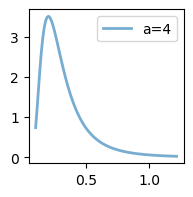

In [4]:
aa = 4
plt.figure(figsize=(2, 2))
x = np.linspace(invgamma.ppf(0.01, aa), invgamma.ppf(0.99, aa), 100)
plt.plot(x, invgamma.pdf(x, aa), lw=2, alpha=0.6, label=f"a={aa}")
_ = plt.legend()

In [5]:
class flat_dist:
    def logpdf(self, x):
        return 0


# describes priors for all leaves independently on each branch
# the prior on p (the number of components) is assumed to be uniform in [n_leaves_min,n_leaves_max]
sigma2_param = 2
priors = {
    "components": ProbDistContainer(
        {
            0: uniform_dist(-50, 50),  # beta
            1: uniform_dist(t.min(), t.max()),  # tau
        }
    ),
    "common": ProbDistContainer(
        {
            0: flat_dist(),  # alpha0
            1: invgamma(sigma2_param),  # sigma2
        }
    ),
}

## Sampler

**TODO sampler**

Add transformation so that 1) we sample log_sigma instead of sigma2, and 2) the components are ordered
1. Scale of ball around the estimate Y.mean() depends on the data. Same problem as with the prior above.
2. Tune parameters of moves on-the-fly?
3. GroupStretchMove or GaussianMove (does this use the ensemble capabilities?).
4. Check acceptance rate and use it to select optimal scaling parameters on the moves (far from 0 and 1)
5. RJMCMC move (?) --> sample from conditional distribution on the rest of the parameters.
6. Multiple Try RJMCMC --> num_try?
7. Label switching; order component means (?)

In [20]:
# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 6

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and sigma2 from prior
coords["components"] = priors["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"])
)
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

# set initial values for alpha0
scale_alpha0 = 0.5
coords["common"][:, :, 0, 0] = norm(loc=Y.mean(), scale=scale_alpha0).rvs(
    size=(ntemps, nwalkers)
)

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any (ntemp,nwalkers),
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used because nleaves_min=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

In [16]:
# number of steps
nsteps = 500
thin_by = 1
burn = 1000

# number of cores
njobs = 8

# moves
factor = 0.0001
cov = {branch: np.diag(np.ones(ndims[branch])) * factor for branch in branch_names}
move_gaussian = GaussianMove(cov)

move_stretch = StretchMove()

# rj moves
num_try = 2
rjmoveMT = MTDistGenMoveRJ(  # multiple-try distgen from prior
    {"components": priors["components"]},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
    num_try=num_try,
    rj=True,
)

rjmove = DistributionGenerateRJ(  # distgen from prior
    {"components": priors["components"]},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
)

# re-set random seed for reproducible sampling
np.random.seed(42)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        log_likelihood,
        priors,
        args=[t, X, Y],
        pool=pool,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=move_stretch,
        rj_moves=rjmoveMT,
    )

    # setup starting state
    state = State(coords)

    # run the sampler
    print("Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

/home/antcc/.micromamba/envs/python-scientific/lib/python3.11/site-packages/eryn/ensemble.py:442: UserWarning: If using revisible jump, using the Stretch Move for in-model proposals is not advised. It will run and work, but it will not be using the correct complientary group of parameters meaning it will most likely be very inefficient.
  warnings.warn(


Sampling posterior distribution...


100%|██████████| 500/500 [00:13<00:00, 35.96it/s]


## Analysis

In [10]:
### print(last_sample.branches["components"].nleaves)
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0, 0, :])
print(last_sample.branches_coords["common"][0, 0, :])

[ True  True  True False  True]
[[ 4.43467571  0.59901009]
 [10.47040634  0.79515546]
 [-3.76485031  0.09815477]
 [-0.16481682  0.78092659]
 [-0.41722519  0.03913962]]
[[4.55757002 0.84877759]]


In [11]:
print("Acceptance % (T=1)\n", 100 * ensemble.acceptance_fraction[0])
print("RJ Acceptance % (T=1)\n", 100 * ensemble.rj_acceptance_fraction[0])

Acceptance % (T=1)
 [3.2 4.  1.2 2.6 0.4 4.8 3.  1.6 3.  1.8 1.2 1.6 1.6 2.6 1.6 0.8 4.4 2.4
 1.6 3.  1.4 1.4 1.6 2.  1.4 3.2 2.  2.2 2.8 2.  2.8 1.4]
RJ Acceptance % (T=1)
 [1.4 1.  0.4 0.8 0.4 0.4 2.  1.2 0.8 1.  1.6 1.  1.2 1.4 2.6 1.  1.4 0.8
 1.  1.  0.  0.8 1.8 2.2 1.2 2.2 0.4 1.8 0.4 1.2 1.4 0.8]


Posterior distribution p|D of the number of components accross all walkers


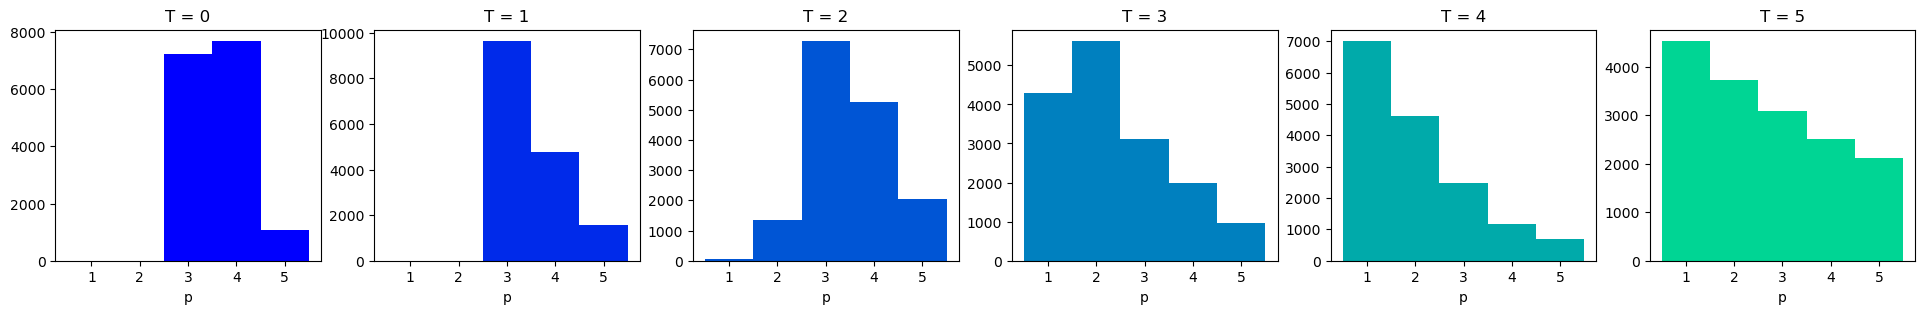

In [12]:
print("Posterior distribution p|D of the number of components accross all walkers")

nleaves = ensemble.get_nleaves()["components"]
bins = np.arange(1, nleaves_max["components"] + 2) - 0.5
colors = plt.get_cmap("winter")

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    color = colors(temp / ntemps)
    ax_t.set_title("T = " + str(temp))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bins, color=color)

**TODO** hacer los plots bonitos con todas las variables.

Posterior distribution and trace accross all walkers (T=1)
  * right now, we are only showing the first component (across the first walker)


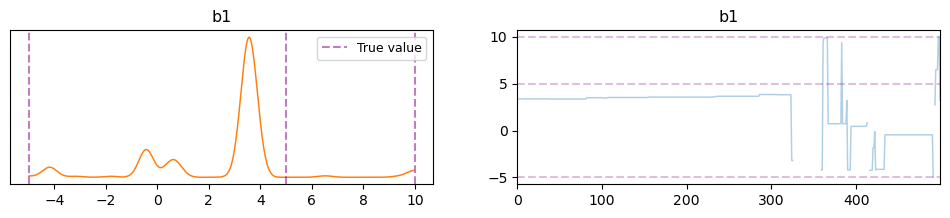

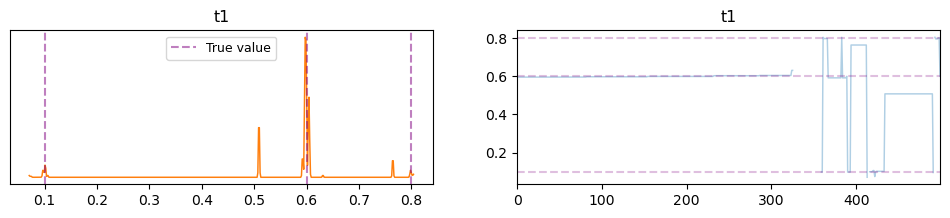

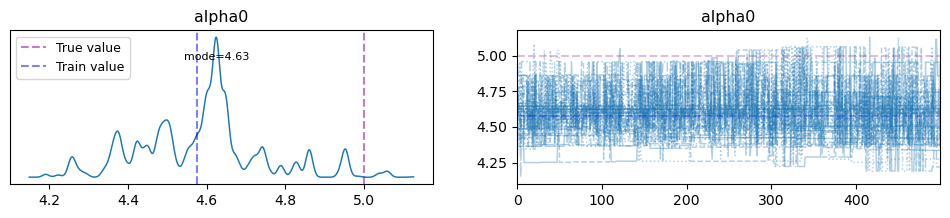

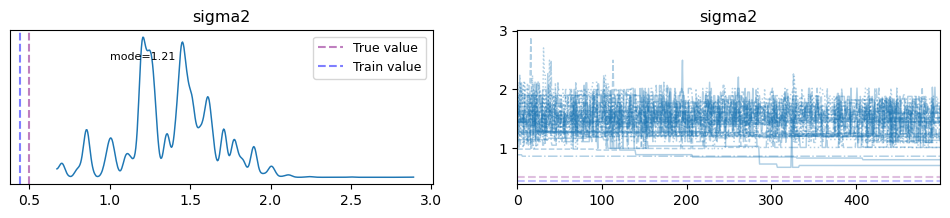

In [18]:
def plot_trace(
    chain_eryn,
    T=0,
    var_name="x",
    true_value=None,
    train_value=None,
    mode=False,
    az_kwargs={},
):
    # Get chain (nwalkers, nsamples)
    chain = np.atleast_2d(chain_eryn[:, T])
    if chain_eryn.ndim == 3:
        chain = chain.swapaxes(0, 1)

    # Plot marginal posterior and trace
    ax = az.plot_trace(
        chain, combined=True, labeller=MapLabeller({"x": var_name}), **az_kwargs
    )

    # Plot reference values
    handles = []
    if true_value is not None:
        true_value = np.atleast_1d(true_value)
        for i, value in enumerate(true_value):
            h = ax[0, 0].axvline(
                x=value, color="purple", linestyle="--", alpha=0.5, label="True value"
            )
            ax[0, 1].axhline(y=value, color="purple", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if train_value is not None:
        train_value = np.atleast_1d(train_value)
        for i, value in enumerate(train_value):
            h = ax[0, 0].axvline(
                x=value, color="b", linestyle="--", alpha=0.5, label="Train value"
            )
            ax[0, 1].axhline(y=value, color="b", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if mode:
        # Compute mode
        arr, density = az.kde(chain)
        mode = arr[np.argmax(density)]

        ax[0, 0].text(
            mode,
            ax[0, 0].get_ylim()[1] * 0.8,
            f"mode={mode:.2f}",
            horizontalalignment="center",
            fontsize=8,
        )

    if true_value is not None or train_value is not None:
        ax[0, 0].legend(handles=handles, fontsize=9)


# Get chain from sampler
chain = ensemble.get_chain(discard=0)

components_all = chain["components"]
inds_components = ensemble.get_inds()["components"]
components = components_all[inds_components]  # same as components_all[~np.isnan]
b_all_models = components_all[..., :1, 0, 0]
t_all_models = components_all[..., :1, 0, 1]

common = chain["common"].squeeze()
alpha0_chain = common[..., 0]
sigma2_chain = common[..., 1]

# Plot trace
print("Posterior distribution and trace accross all walkers (T=1)")
print(
    "  * right now, we are only showing the first component (across the first walker)"
)
plot_trace(
    b_all_models, 0, "b1", component_params[:, 0], az_kwargs={"chain_prop": "color"}
)
plot_trace(
    t_all_models, 0, "t1", component_params[:, 1], az_kwargs={"chain_prop": "color"}
)
plot_trace(alpha0_chain, 0, "alpha0", alpha0, Y.mean(), mode=True)
plot_trace(
    sigma2_chain,
    0,
    "sigma2",
    sigma2,
    np.var(y[idx_train] - y_noiseless[idx_train]),
    mode=True,
)